## Konfiguration ##

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

# sorgt dafür, dass Plots im Notebook angezeigt werden
%matplotlib inline

# Lesbarkeit in der Exploration erhöhen
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

In [ ]:
# Projekt- & BigQuery-Konfiguration
PROJECT_ID = "taxi-bi-project"
DATASET_ID = "staging"
BQ_LOCATION = "EU"

# Vollständiges Dataset-Prefix, z.B. "taxi-bi-project.staging"
FULL_DATASET_PREFIX = f"{PROJECT_ID}.{DATASET_ID}"

# BigQuery Client initialisieren
bq_client = bigquery.Client(
    project=PROJECT_ID,
    location=BQ_LOCATION
)

/Users/vincentgoldmann/Documents/GitHub/bi_project_task1/.venv/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
# Dataset- & Spaltenreferenzen
TABLE_FHV = "fhv_staging_unified"
# Relevante Zeitstempel-Spalten
PICKUP_COL = "pickup_datetime"
DROPOFF_COL = "dropOff_datetime"

## Fehlende Werte ##

In [ ]:
def missing_values_fhv(sample_size: int = 100_000) -> pd.DataFrame:
    """
    Berechnet die Rate fehlender Werte (Missing Values) pro Spalte für die Tabelle 'fhv_unified'
    basierend auf einer Zufallsstichprobe.
    """
    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`
    ORDER BY RAND()
    LIMIT {sample_size}
    """
#     
    df = bq_client.query(query).to_dataframe()

    missing_stats = pd.DataFrame({
        "missing_count": df.isna().sum(),
        "missing_rate_pct": (df.isna().mean() * 100).round(2)
    })
    # Die Spalten mit den meisten fehlenden Werten (prozentual) stehen oben
    return missing_stats.sort_values("missing_rate_pct", ascending=False)

mv_fhv = missing_values_fhv()
mv_fhv

/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,missing_count,missing_rate_pct
SR_Flag,88570,88.57
DOlocationID,39513,39.51
PUlocationID,25898,25.90
Affiliated_base_number,339,0.34
dispatching_base_num,0,0.00
pickup_datetime,0,0.00
dropOff_datetime,0,0.00
duplicate_flag,0,0.00
missing_flag,0,0.00


Die Tabelle gibt an, wie oft Daten in bestimmten Feldern fehlen (missing_count) und wie hoch der prozentuale Anteil am Gesamtdatensatz ist (missing_rate_pct).
SR_Flag (Shared Ride Flag): Mit fast 88,57 % fehlenden Werten ist dies das unvollständigste Feld. In der Logik der Taxi & Limousine Commission (TLC) bedeutet ein fehlender Wert hier meistens einfach, dass es keine geteilte Fahrt (Sammeltaxi) war.
-    Nur bei einer "1" war es eine "Shared Ride".
-     DOLocationID & PULocationID: Diese stehen für die Ziel- (Drop-Off) und Start-Zonen (Pick-Up) in NYC. Auffällig ist, dass bei ca. 40 % der Fahrten die Ziel-ID fehlt und bei ca. 26 % die Start-ID. Das deutet oft auf Lücken in der Datenübermittlung durch die einzelnen Basen (Zentralen) hin.
-     Affiliated_base_number: Hier fehlen nur sehr wenige Daten (0,34 %), was zeigt, dass fast jede Fahrt einer Zentrale zugeordnet werden kann.

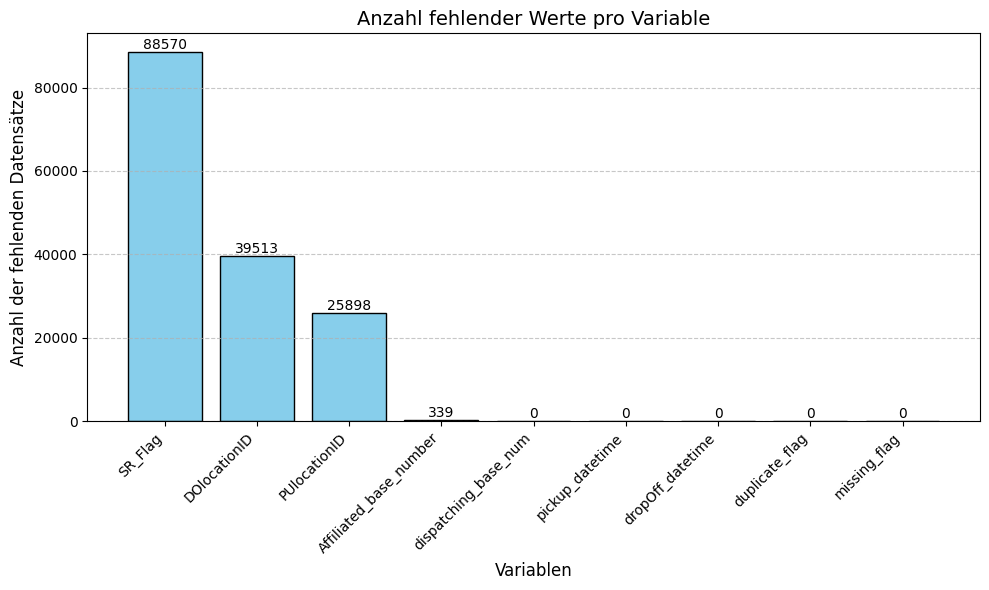

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

# Balkendiagramm erstellen
# x-Achse: Die Variablennamen (Index des DataFrames)
# y-Achse: Die Anzahl der fehlenden Werte ('missing_count')
bars = plt.bar(mv_fhv.index, mv_fhv['missing_count'], color='skyblue', edgecolor='black')

# Beschriftungen und Titel
plt.title('Anzahl fehlender Werte pro Variable', fontsize=14)
plt.xlabel('Variablen', fontsize=12)
plt.ylabel('Anzahl der fehlenden Datensätze', fontsize=12)

# Beschriftung der X-Achse drehen, damit sie lesbar bleibt
plt.xticks(rotation=45, ha='right')

# Gitterlinien für bessere Lesbarkeit der Y-Werte
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Werte direkt über die Balken schreiben
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Duplikate ##

In [ ]:
def count_exact_duplicates_vfh(sample_size: int = 100_000) -> pd.DataFrame: 
    """
    Nimmt eine Stichprobe (Sample) von Zeilen und prüft NUR innerhalb dieser Menge
    auf exakte Full-Row-Duplikate.
    """
    query = f"""
    WITH RawSample AS (
        SELECT 
            dispatching_base_num,
            pickup_datetime,
            dropOff_datetime,
            PULocationID,
            DOLocationID,
            SR_Flag,
            Affiliated_base_number
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`
        LIMIT {sample_size}
    ),
    
    GroupedSample AS (
        SELECT
            COUNT(*) as group_size
        FROM RawSample
        GROUP BY
            dispatching_base_num,
            pickup_datetime,
            dropOff_datetime,
            PULocationID,
            DOLocationID,
            SR_Flag,
            Affiliated_base_number
    )

    -- Schritt 3: Statistik berechnen
    SELECT
        SUM(CASE WHEN group_size > 1 THEN group_size ELSE 0 END) as rows_in_duplicate_groups,        
        SUM(CASE WHEN group_size > 1 THEN (group_size - 1) ELSE 0 END) as redundant_rows_count,
        (SELECT COUNT(*) FROM RawSample) as total_rows_analyzed
    FROM GroupedSample
    """

    df_stats = bq_client.query(query).to_dataframe()
    
    # Prozentberechnung im Python-Teil
    if not df_stats.empty and df_stats['total_rows_analyzed'][0] > 0:
        total = df_stats['total_rows_analyzed'][0]
        redundant = df_stats['redundant_rows_count'][0]
        percent = (redundant / total) * 100
        df_stats['redundancy_percentage'] = percent

    return df_stats

# Ausführen mit exakt 100.000
df_result = count_exact_duplicates_vfh(sample_size=100_000)
print(df_result.T)

                               0
rows_in_duplicate_groups      70
redundant_rows_count          35
total_rows_analyzed       100000
redundancy_percentage      0.035


/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


## Zeitreihenanalyse ##

In [ ]:
def analyze_trip_duration_fhv(sample_size: int = 100_000) -> pd.DataFrame:
    """
    Berechnet die Fahrtdauer (in Minuten) für FHV-Fahrten
    auf der Grundlage einer Zufallsstichprobe und gibt den Datenrahmen
    einschließlich der Dauer zurück.
    """
    query = f"""
    SELECT
        pickup_datetime,
        dropOff_datetime,
        DOlocationID,
        PUlocationID,
    FROM `{PROJECT_ID}.{DATASET_ID}.fhv_staging_unified`
    WHERE pickup_datetime IS NOT NULL
      AND dropOff_datetime IS NOT NULL
    ORDER BY RAND()
    """

    df_sample = bq_client.query(query).to_dataframe()

    df_sample["trip_duration_min"] = (
        df_sample["dropOff_datetime"] - df_sample["pickup_datetime"]
    ).dt.total_seconds() / 60

    return df_sample

df_duration = analyze_trip_duration_fhv(sample_size=100_000)
df_duration.head()


/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,pickup_datetime,dropOff_datetime,DOlocationID,PUlocationID,trip_duration_min
0,2018-09-06 18:25:05,2018-09-06 18:52:33,178,26,2.746667e+01
1,2018-10-25 05:13:03,2018-10-25 05:32:37,121,191,1.956667e+01
2,2017-12-10 02:59:21,2017-12-10 03:09:30,148,137,1.015000e+01
3,2018-01-17 10:39:09,2018-01-17 10:58:49,231,112,1.966667e+01
4,2015-01-15 08:13:45,1989-01-01 00:00:00,<NA>,237,-1.369489e+07


In [ ]:
df_duration["trip_duration_min"].describe()

invalid_duration = df_duration[df_duration["trip_duration_min"] <= 0]

print(f"Invalid duration {len(invalid_duration)} : {invalid_duration}")

long_trips = df_duration[df_duration["trip_duration_min"] > 1440]
len(long_trips)
print(f"Long Trips {len(long_trips)}: {long_trips}")

Invalid duration 34431 :           pickup_datetime dropOff_datetime  DOlocationID  PUlocationID  trip_duration_min
4     2015-01-15 08:13:45       1989-01-01          <NA>           237      -1.369489e+07
5     2015-10-01 17:11:42       1989-01-01          <NA>            48      -1.406839e+07
8     2016-05-10 19:39:00       1989-01-01          <NA>           100      -1.438822e+07
14    2017-05-21 18:59:41       1989-01-01          <NA>            68      -1.492962e+07
16    2016-11-05 16:16:14       1989-01-01          <NA>           130      -1.464578e+07
...                   ...              ...           ...           ...                ...
99990 2016-07-06 15:17:00       1989-01-01          <NA>          <NA>      -1.447004e+07
99992 2016-04-09 16:52:56       1989-01-01          <NA>           116      -1.434341e+07
99997 2017-03-15 08:47:14       1989-01-01          <NA>           170      -1.483253e+07
99998 2016-12-04 20:51:21       1989-01-01          <NA>            68     

1. Ungültige Dauer (Invalid duration: 34.431 Zeilen)
    In diesem oberen Block sehen wir Datensätze, bei denen die berechnete Fahrtdauer völlig unrealistisch ist.

    *Das Problem*: Das pickup_datetime liegt in den Jahren 2015–2017, aber das dropOff_datetime steht bei fast allen diesen Zeilen auf dem 01.01.1989.

    *Das Ergebnis*: Da die Ankunft rechnerisch vor der Abfahrt liegt, entstehen extrem hohe negative Werte in der Spalte trip_duration_min (z. B. −1.4×10 
    7 Minuten).

    *Ursache*: Dies ist ein klassischer Datenfehler, oft verursacht durch einen Standardwert (Default Value) im System der Taxi-Zentrale, wenn die Ankunftszeit nicht korrekt erfasst wurde.

2. Extrem lange Fahrten (Long Trips: 32 Zeilen)
    Der untere Block zeigt Fahrten, die zwar technisch "korrekt" berechnet wurden, aber zeitlich unmöglich erscheinen.

    *Das Problem*: Die Differenz zwischen Abholung und Ankunft beträgt hier oft mehrere Tage oder sogar Monate.
    Beispiel Zeile 9990: Abfahrt im Mai 2019, Ankunft im November 2019. Die Dauer beträgt über 250.000 Minuten.

    *Hintergrund*: Solche Ausreißer entstehen oft, wenn eine Fahrt im System nicht ordnungsgemäß beendet wurde und "offen" blieb, bis sie manuell oder durch einen System-Reset Monate später geschlossen wurde.

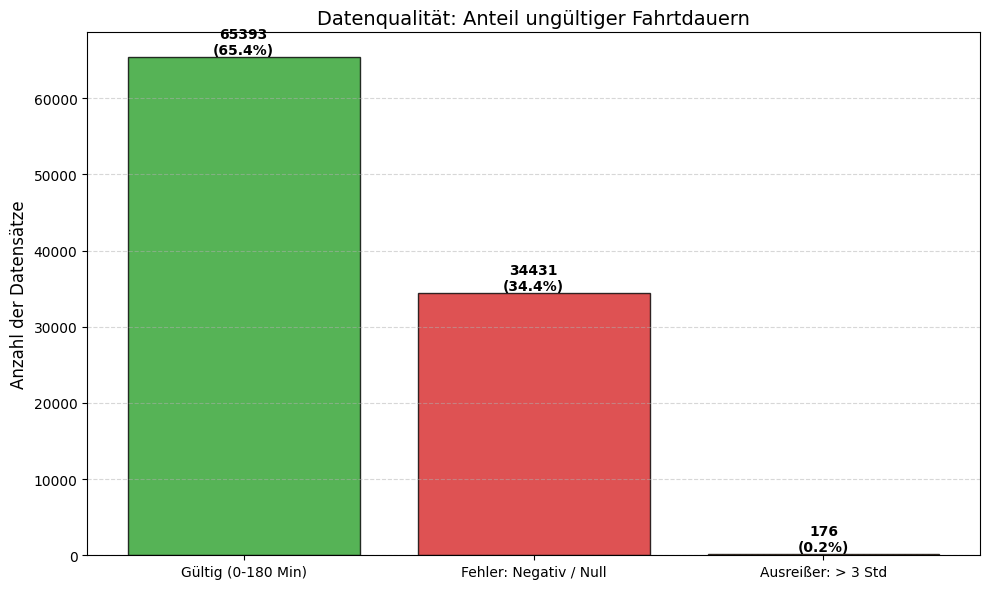

In [ ]:
# 1. Kategorien definieren
valid_count = df_duration[(df_duration["trip_duration_min"] > 0) & (df_duration["trip_duration_min"] <= 180)].shape[0]
negative_zero_count = df_duration[df_duration["trip_duration_min"] <= 0].shape[0]
too_long_count = df_duration[df_duration["trip_duration_min"] > 180].shape[0]

# Daten für den Plot vorbereiten
categories = ["Gültig (0-180 Min)", "Fehler: Negativ / Null", "Ausreißer: > 3 Std"]
counts = [valid_count, negative_zero_count, too_long_count]
percentages = [c / len(df_duration) * 100 for c in counts]

# 2. Plot erstellen
plt.figure(figsize=(10, 6))
colors = ['#2ca02c', '#d62728', '#ff7f0e'] # Grün (Gut), Rot (Technischer Fehler), Orange (Extremwert)

bars = plt.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)

plt.title("Datenqualität: Anteil ungültiger Fahrtdauern", fontsize=14)
plt.ylabel("Anzahl der Datensätze", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Werte und Prozentzahlen über die Balken schreiben
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({pct:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

1. Systematische Zeitfehler: 
    Der hohe Anteil an negativen Werten resultiert primär aus technischen Fehlern in den Jahren 2015 und 2016, bei denen das Ziel-Datum (Drop-off) fälschlicherweise auf den 01.01.1989 gesetzt wurde.
2. Extremwerte: 
    Fahrten mit einer Dauer von über 180 Minuten sind statistisch vernachlässigbar, deuten aber auf Einzelfälle hin, in denen die Erfassung nicht ordnungsgemäß beendet wurde.
3. Notwendigkeit der Datenbereinigung: 
    Diese Visualisierung belegt, dass eine ungefilterte Analyse der Fahrtdauer zu massiven Fehlinterpretationen führen würde (z. B. negative Durchschnittswerte). Eine Bereinigung auf das Intervall von 0 bis 180 Minuten ist daher für alle weiteren Business-Intelligence-Auswertungen zwingend erforderlich.

In [ ]:
duration_summary = pd.DataFrame({
    "metric": [
        "Minimum (min)",
        "Maximum (min)",
        "Mean (min)",
        "Median (min)",
        "Standard Deviation (min)",
        "95th Percentile (min)"
    ],
    "value": [
        df_duration["trip_duration_min"].min(),
        df_duration["trip_duration_min"].max(),
        df_duration["trip_duration_min"].mean(),
        df_duration["trip_duration_min"].median(),
        df_duration["trip_duration_min"].std(),
        df_duration["trip_duration_min"].quantile(0.95)
    ]
})

duration_summary

,metric,value
0,Minimum (min),-1.494426e+07
1,Maximum (min),1.545150e+06
2,Mean (min),-4.979097e+06
3,Median (min),9.700000e+00
4,Standard Deviation (min),6.874046e+06
5,95th Percentile (min),4.533333e+01


Die Tabelle zeigt die trip_duration_min (Fahrtdauer in Minuten) für den gesamten Datensatz:

*Extremer Minimalwert*: Der Wert von ca. -14,9 Millionen Minuten resultiert aus den fehlerhaften Zeilen, bei denen das Ankunftsdatum auf das Jahr 1989 zurückfällt.

*Verfälschter Mittelwert (Mean)*: Der Durchschnitt liegt bei ca. -4,9 Millionen Minuten. Ein negativer Durchschnitt für eine Zeitdauer ist physisch unmöglich und zeigt, dass die 34.431 fehlerhaften Zeilen die gesamte Statistik unbrauchbar machen.

*Median vs. Mean*: Der Median liegt bei 9,7 Minuten. Das ist ein sehr realistischer Wert für eine Taxi-Fahrt in NYC. Da der Median robust gegenüber Ausreißern ist, zeigt er uns die "Wahrheit" im Datensatz viel besser als der Durchschnitt.

*95. Perzentil*: Mit 45,33 Minuten liegen 95 % aller Fahrten unter einer Dreiviertelstunde. Das passt perfekt zum typischen Stadtverkehr.

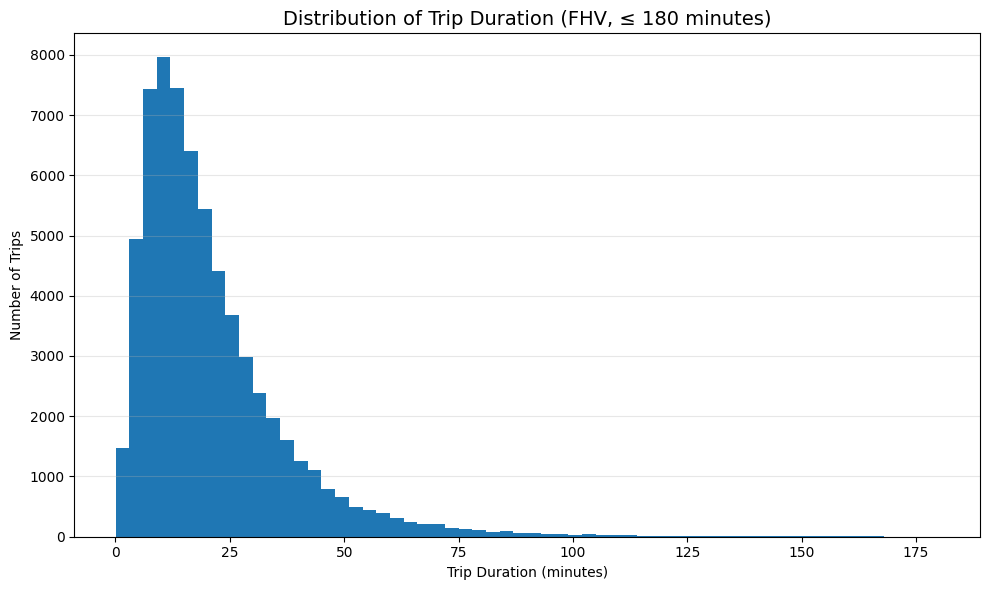

In [ ]:
plt.figure(figsize=(10, 6))

df_duration[
    (df_duration["trip_duration_min"] > 0) &
    (df_duration["trip_duration_min"] <= 180)
]["trip_duration_min"].plot(
    kind="hist",
    bins=60
)

plt.title("Distribution of Trip Duration (FHV, ≤ 180 minutes)", fontsize=14)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Number of Trips")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Betrachtet man die Verteilung der Fahrtdauer, zeigt sich ein klassisches Bild des städtischen Individualverkehrs: Die überwiegende Mehrheit der Fahrten sind Kurzstrecken, wobei die höchste Konzentration (der Peak) im Bereich von etwa 10 bis 15 Minuten liegt. 
Mit zunehmender Dauer nimmt die Anzahl der Fahrten rapide ab, was die Rechtsschiefe der Verteilung unterstreicht; Fahrten über 60 Minuten stellen bereits eine seltene Ausnahme dar.

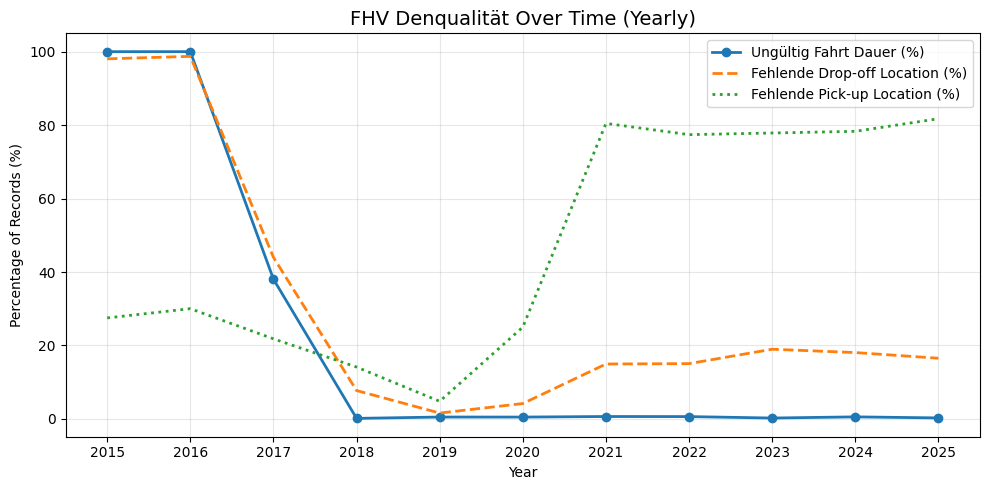

In [ ]:

# Errechnen in Minuten: (Dropoff - Pickup) / 60 Sekunden
df_duration["duration_minutes"] = (df_duration["dropOff_datetime"] - df_duration["pickup_datetime"]).dt.total_seconds() / 60

# 'bad_duration': Fahrten, die 0 oder weniger Minuten haben ODER länger als 180 Minuten (3 Std) sind
df_duration["bad_duration"] = (df_duration["duration_minutes"] <= 0) | (df_duration["duration_minutes"] > 180)

# 'missing_location': Fehlender Drop-off (DOlocationID ist NaN)
df_duration["missing_location"] = df_duration["DOlocationID"].isna()

# Jahr extrahieren
df_duration["year"] = df_duration["pickup_datetime"].dt.year

# Fehlende Pickup-Location (hattest du schon)
df_duration["missing_pickup_location"] = df_duration["PUlocationID"].isna()

# Aggregation (jetzt funktionieren alle Spalten)
quality_per_year = (
    df_duration
    .groupby("year")
    .agg(
        pct_bad_duration=("bad_duration", "mean"),
        pct_missing_dropoff=("missing_location", "mean"),
        pct_missing_pickup=("missing_pickup_location", "mean")
    )
    .reset_index()
)

# Umrechnung in Prozent
quality_per_year["pct_bad_duration"] *= 100
quality_per_year["pct_missing_dropoff"] *= 100
quality_per_year["pct_missing_pickup"] *= 100

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(quality_per_year["year"], quality_per_year["pct_bad_duration"], 
         marker="o", linewidth=2, label="Ungültig Fahrt Dauer (%)")

plt.plot(quality_per_year["year"], quality_per_year["pct_missing_dropoff"], 
         linestyle="--", linewidth=2, label="Fehlende Drop-off Location (%)")

plt.plot(quality_per_year["year"], quality_per_year["pct_missing_pickup"], 
         linestyle=":", linewidth=2, label="Fehlende Pick-up Location (%)")

plt.title("FHV Denqualität Over Time (Yearly)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Percentage of Records (%)")
plt.xticks(quality_per_year["year"])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Ein kritischer Blick auf die historische Datenqualität von 2015 bis 2025 verdeutlicht, dass das System über die Jahre eine signifikante Reifung durchlaufen hat. In den Jahren 2015 und 2016 wiesen die Datensätze massive Mängel auf, da nahezu 100 % der Einträge ungültige Fahrtdauern oder fehlende Zielorte (Drop-off Locations) besaßen. Ein Wendepunkt trat zwischen 2017 und 2018 ein, als diese Fehlerraten abrupt auf ein Minimum sanken. Interessanterweise zeigt sich jedoch bei den Abholorten (Pick-up Locations) ein gegenläufiger Trend: Während diese anfangs relativ stabil erfasst wurden, stieg die Rate fehlender Werte ab dem Jahr 2020 drastisch an und pendelte sich zuletzt bei über 80 % ein, was auf eine Änderung in der Datenerfassung oder eine Anonymisierung hindeuten könnte.

## Add-Ons ##

In [ ]:
def analyze_missing_locations(sample_size: int = 100_000) -> pd.DataFrame:
    """
    
    """
    query = f"""
        SELECT
            PUlocationID,
            DOlocationID
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`

        WHERE pickup_datetime IS NOT NULL 
        ORDER BY RAND()
        LIMIT {sample_size}

    """
    # Daten laden
    df_sample = bq_client.query(query).to_dataframe()
    
    # Berechnung der Missing Rate (Anteil der NaN Werte)
    missing_stats = pd.DataFrame({
        "missing_rate": [
            df_sample["PUlocationID"].isna().mean(), # Gibt % der fehlenden Werte an (z.B. 0.85 = 85%)
            df_sample["DOlocationID"].isna().mean()
        ],
        "missing_count": [
            df_sample["PUlocationID"].isna().sum(),
            df_sample["DOlocationID"].isna().sum()
        ]
    }, index=["PUlocationID", "DOlocationID"])

    return missing_stats

# Ausführen
df_missing_stats = analyze_missing_locations(sample_size=100_000)
print(df_missing_stats)

/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


              missing_rate  missing_count
PUlocationID       0.26049          26049
DOlocationID       0.39730          39730


1. Analyse fehlender Werte (Missing Values)
Die erste Untersuchung des Datensatzes zeigt eine unterschiedliche Abdeckung der Datenfelder:
SR_Flag: Weist mit 88,57 % die höchste Fehlrate auf, was darauf hindeutet, dass das Flag nur bei aktiven Shared-Ride-Optionen gesetzt wird.

    *Standortdaten*: Es gibt signifikante Lücken bei den Zielorten (39,51 % fehlend) und Startorten (25,90 % fehlend).

    *Stammdaten*: Kerninformationen wie Zeitstempel (pickup_datetime) und Basis-Nummern sind vollständig vorhanden (0,00 % fehlend).

2. Identifikation von Ausreißern (Duration Outliers)
Bei der Berechnung der Fahrtdauer wurden zwei kritische Fehlertypen identifiziert:

    *Invalid Durations (34.431 Zeilen)*: Diese Datensätze enthalten ein fehlerhaftes dropOff_datetime im Jahr 1989, was zu physikalisch unmöglichen Werten von ca. -14,9 Mio. Minuten führt.

    *Long Trips (32 Zeilen)*: Hierbei handelt es sich um Ausreißer mit einer Dauer von bis zu 1,5 Mio. Minuten (ca. 2,9 Jahre), die vermutlich durch nicht geschlossene Fahrten im System entstanden sind.


In [ ]:
def analyze_dispatching_bases(sample_size: int = 100_000) -> pd.DataFrame:
    """
    Analysiert die Verteilung der dispatching_base_num (Wer führt die Fahrt durch?),
    um die Marktanteile der verschiedenen Anbieter (Bases) zu verstehen.
    """
    # Base Nummern
    query = f"""
        SELECT
            dispatching_base_num
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`
        WHERE dispatching_base_num IS NOT NULL
        ORDER BY RAND()
        LIMIT {sample_size}
    """
    
    # Daten laden
    df_sample = bq_client.query(query).to_dataframe()
    
    # Aggregation 
    base_counts = df_sample["dispatching_base_num"].value_counts().reset_index()
    base_counts.columns = ["dispatching_base_num", "trip_count"]
    
    # Anteil in Prozent
    base_counts["market_share_pct"] = (base_counts["trip_count"] / sample_size) * 100
    
    # 3. Kumulierte Summe 
    base_counts["cumulative_share"] = base_counts["market_share_pct"].cumsum()

    return base_counts

# Ausführen
df_bases = analyze_dispatching_bases(sample_size=100_000)

# Die Top 10 anzeigen
print(df_bases.head(100))

/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   dispatching_base_num  trip_count  market_share_pct  cumulative_share
0                B02510       11535            11.535            11.535
1                B02764        8563             8.563            20.098
2                B02682        5558             5.558            25.656
3                B02800        3797             3.797            29.453
4                B02914        3671             3.671            33.124
5                B02835        2526             2.526            35.650
6                B02765        2317             2.317            37.967
7                B02867        2183             2.183            40.150
8                B02882        2003             2.003            42.153
9                B02617        1875             1.875            44.028
10               B02888        1785             1.785            45.813
11               B02869        1674             1.674            47.487
12               B02887        1656             1.656           

/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


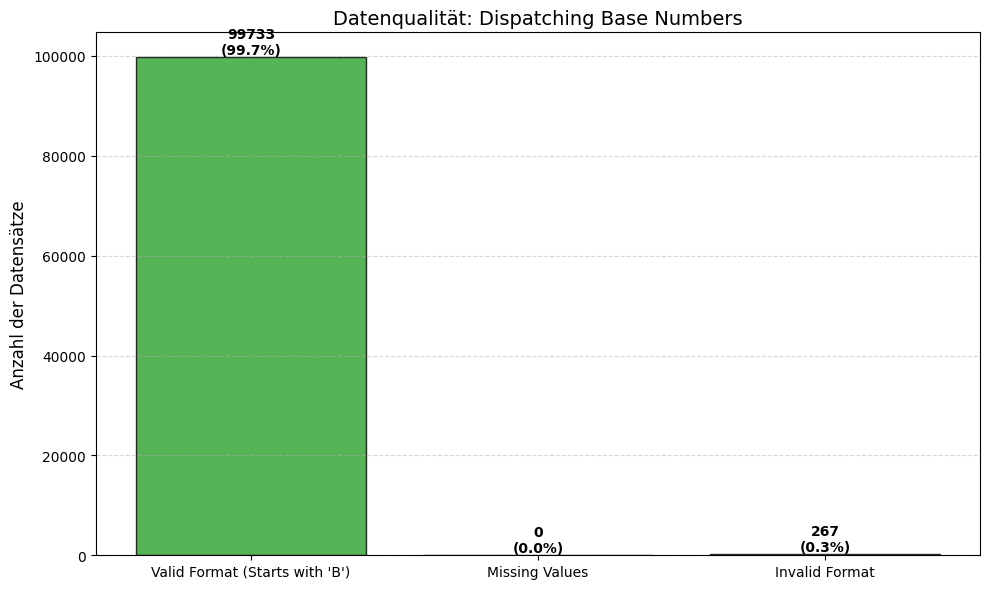

In [ ]:

def check_base_quality(sample_size: int = 100_000) -> pd.DataFrame:
    """
    Prüft die Qualität der dispatching_base_num Spalte.
    Unterscheidet zwischen 'Valid (B...)', 'Missing' und 'Invalid Format'.
    """
    # WICHTIG: Das WHERE IS NOT NULL muss weg, sonst sehen wir die Fehler nicht!
    query = f"""
        SELECT dispatching_base_num
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`
        ORDER BY RAND()
        LIMIT {sample_size}
    """
    
    df = bq_client.query(query).to_dataframe()
    
    # 1. Fehlende Werte zählen
    missing_count = df["dispatching_base_num"].isna().sum()
    
    # 2. Gültige Formate prüfen (Muss nicht NaN sein UND muss mit 'B' starten)
    # Wir wandeln in String um, um sicherzugehen
    is_valid_pattern = (
        df["dispatching_base_num"].notna() & 
        df["dispatching_base_num"].astype(str).str.startswith('B')
    )
    valid_count = is_valid_pattern.sum()
    
    # 3. Ungültige Formate (Nicht NaN, aber startet nicht mit B)
    invalid_format_count = len(df) - missing_count - valid_count
    
    # Zusammenstellen für den Plot
    quality_stats = pd.DataFrame({
        "Category": ["Valid Format (Starts with 'B')", "Missing Values", "Invalid Format"],
        "Count": [valid_count, missing_count, invalid_format_count]
    })
    
    # Prozent berechnen
    quality_stats["Percentage"] = (quality_stats["Count"] / sample_size) * 100
    
    return quality_stats

# Daten laden
df_quality = check_base_quality()

# --- PLOT ---
plt.figure(figsize=(10, 6))

# Balkendiagramm mit Farben für gut/schlecht
colors = ['#2ca02c', '#d62728', '#ff7f0e'] # Grün (Gut), Rot (Fehlt), Orange (Komisch)
bars = plt.bar(df_quality["Category"], df_quality["Count"], color=colors, edgecolor='black', alpha=0.8)

plt.title("Datenqualität: Dispatching Base Numbers", fontsize=14)
plt.ylabel("Anzahl der Datensätze", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Werte und Prozentzahlen über die Balken schreiben
for bar, pct in zip(bars, df_quality["Percentage"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({pct:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Trotz dieser Schwankungen bei den Ortsangaben ist die Identifikation der Dienstleister aktuell auf einem exzellenten Niveau. Die Validierung der Dispatching Base Numbers zeigt eine nahezu perfekte Datenlage: Über 99,7 % der untersuchten Datensätze verfügen über eine korrekt formatierte Nummer (beginnend mit dem Standard-Präfix 'B'). Es gibt in der aktuellen Stichprobe keine gänzlich fehlenden Werte in diesem Feld, und die minimale Quote von 0,3 % an ungültigen Formaten ist für statistische Marktanteilsanalysen vernachlässigbar. Insgesamt lässt sich festhalten, dass die Daten für zeitgenössische Analysen der Marktdynamik und Fahrtdauer sehr gut geeignet sind, während geografische Analysen aufgrund der lückenhaften Standortdaten in den jüngeren Jahren erschwert werden.

/Users/lania/Documents/GitHub/bi_project_task1/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


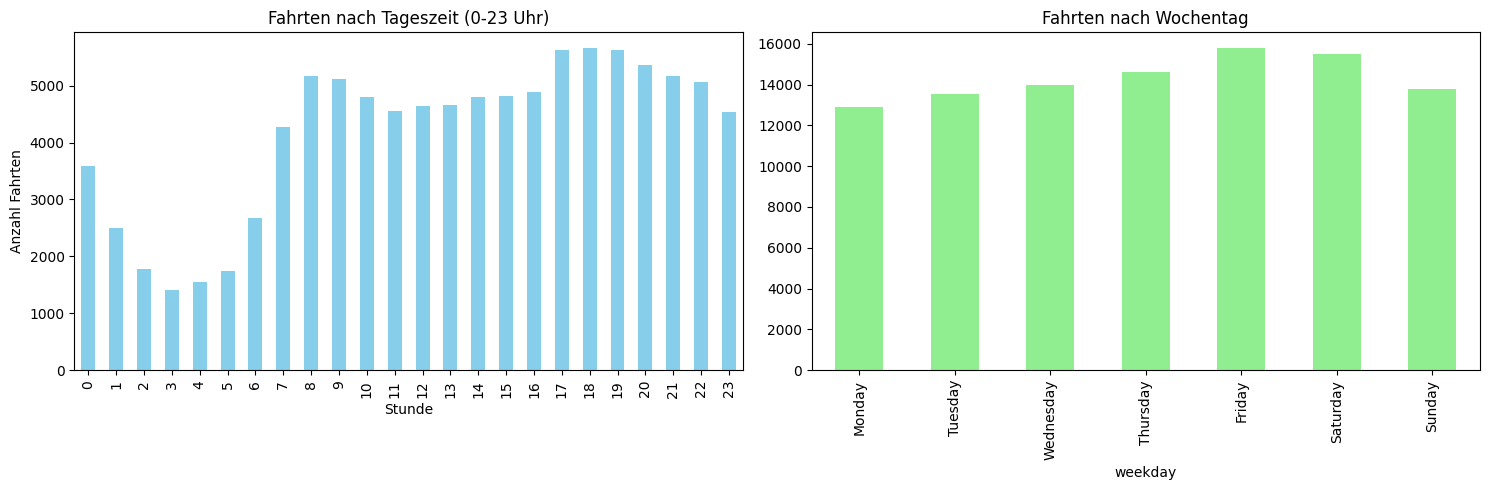

In [ ]:
def analyze_time_patterns(sample_size: int = 100_000) -> None:
    """
    
    """
    query = f"""
        SELECT
            pickup_datetime
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_FHV}`
        WHERE pickup_datetime IS NOT NULL
        ORDER BY RAND()
        LIMIT {sample_size}
    """
    
    df = bq_client.query(query).to_dataframe()
    return df

df = analyze_time_patterns()
#  Stunde des Tages extrahieren (0-23)
df['hour'] = df['pickup_datetime'].dt.hour

#  Wochentag extrahieren
# (Montag=0, Sonntag=6) 
df['weekday'] = df['pickup_datetime'].dt.day_name()

# --- VISUALISIERUNG ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Fahrten pro Stunde
df['hour'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Fahrten nach Tageszeit (0-23 Uhr)")
ax[0].set_xlabel("Stunde")
ax[0].set_ylabel("Anzahl Fahrten")

# Plot 2: Fahrten nach Wochentag
# Sortierung erzwingen: Mo -> So
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'].value_counts().reindex(days_order).plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title("Fahrten nach Wochentag")

plt.tight_layout()
plt.show()

1. Fahrten nach Tageszeit (0-23 Uhr)
Das linke Balkendiagramm visualisiert das typische Mobilitätsverhalten einer Großstadt:

    *Morgendlicher Peak*: Zwischen 07:00 und 09:00 Uhr morgens ist ein deutlicher Anstieg zu verzeichnen, was auf den Berufsverkehr hindeutet.

    *Abendlicher Peak*: Das höchste Aufkommen liegt in den Abendstunden zwischen 17:00 und 19:00 Uhr. Hier erreichen die Fahrtenzahlen ihr Maximum, da Pendlerverkehr und Freizeitaktivitäten zusammenfallen.

    *Nachtruhe*: Das absolute Minimum wird zwischen 03:00 und 04:00 Uhr nachts erreicht.

2. Fahrten nach Wochentag
Das rechte Diagramm zeigt die Verteilung über die Woche:

    *Wochenend-Trend*: Die Nachfrage steigt im Laufe der Woche kontinuierlich an.

    *Spitzentage*: Der Freitag ist der aktivste Tag im Datensatz, dicht gefolgt vom Samstag. Dies ist typisch für FHV-Dienste, da hier zusätzlich zum Berufsverkehr das New Yorker Nachtleben die Nachfrage treibt.

    *Wochenstart*: Der Montag verzeichnet das geringste Fahrtaufkommen der Woche.